In [63]:
import pandas as pd
from pathlib import Path
from IPython.display import display, HTML
from Bio import SeqIO

def fasta2df(fn):
    seqs = SeqIO.parse(fn, "fasta")
    df = pd.DataFrame((str(s.id), str(s.seq)) for s in seqs)
    df.columns = ["ID", "Sequence"]
    return df
    
def get_times(time_prefix):
    with open(str(time_prefix) + '.index.time') as f_index_time:
        index_time, index_mem = map(float, f_index_time.readline().split())
        index_mem /= 2**20
        with open(str(time_prefix) + '.time') as f_time:
            total_time, total_mem = map(float, f_time.readline().split())
            total_mem /= 2**20
            map_time = total_time - index_time
            return index_time, map_time, index_mem, total_mem
    
def get_eval(eval_file, total_reads):
    evaldf = pd.read_csv(eval_file, sep='\t', names=['Q', 'quality', 'aligned', 'wrong', 'wrong_frac', 'aligned_cum'])
    aligned = evaldf['aligned'].sum()
    unaligned = total_reads - aligned
    wrong = evaldf['wrong'].sum()
    issue_perc = (100.0 * (wrong + unaligned)  / aligned).round(2)
    return unaligned, aligned, wrong, issue_perc

In [64]:
def get_comparison_table(refname, experiment, tools):
    alldf = pd.DataFrame(columns=['tool', 'unaligned', 'aligned', 'misaligned', 'correct %', 'idx (sec)', 'map (sec)', 'idx (GB)', 'total (GB)'])
    ref = fasta2df(Path('refs') / (refname+'.fa'))
    reads = fasta2df(Path('reads') / Path('reads-'+experiment+'.fa'))
    for tool in tools:
        d = Path("out") / experiment / tool / tool
        eval_file = d.with_suffix('.eval')
        if eval_file.exists():
            unaligned,  aligned,  wrong,     issue_perc = get_eval(eval_file, len(reads))
            index_time, map_time, index_mem, total_mem  = get_times(d)
            alldf.loc[len(alldf.index)] = [tool, unaligned, aligned, wrong, issue_perc, index_time, map_time, index_mem, total_mem]
        else:
            print(f"File {eval_file} does not exist.")
    alldf = alldf.set_index('tool')
    alldf.index.name = None
    return alldf

tools = ['sweepmap', 'sweepmap-slow', 'mapquik', 'blend', 'minimap', 'winnowmap']
#experiments = [('chm13-1B', 'chm13-1B-a0.99-d1-l10000'), ('t2tChrY', 't2tChrY-a0.99-d1-l10000')]
#experiments = [('chm13', 'chm13-a0.99-d1-l10000'), ('t2tChrY', 't2tChrY-a0.99-d1-l10000')]
experiments = [('chm13', 'chm13-a0.99-d1-l10000'), ('t2tChrY', 't2tChrY-a0.99-d1-l10000')]
for refname, data in experiments:
    df = get_comparison_table(refname, data, tools).round(2)
    df.columns.name = data
    css = """ <style> table { font-family: "Courier New", Courier, monospace; } </style> """
    display(HTML(css))
    display(df)
    df = df.astype(str).map(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
    print(df.to_latex(escape=True))

File out/chm13-a0.99-d1-l10000/winnowmap/winnowmap.eval does not exist.


chm13-a0.99-d1-l10000,unaligned,aligned,misaligned,correct %,idx (sec),map (sec),idx (GB),total (GB)
sweepmap,0,155845,1543,0.99,87.95,59.56,22.16,22.16
sweepmap-slow,0,155845,2086,1.34,87.32,527.90,22.16,22.16
mapquik,2260,153585,3284,3.61,29.47,15.82,4.10,4.10
blend,1,155844,1915,1.23,51.13,67.05,5.37,5.37
minimap,1,155844,1104,0.71,75.86,330.47,10.19,10.19


\begin{tabular}{lllllllll}
\toprule
chm13-a0.99-d1-l10000 & unaligned & aligned & misaligned & correct \% & idx (sec) & map (sec) & idx (GB) & total (GB) \\
\midrule
sweepmap & 0 & 155845 & 1543 & 0.99 & 87.95 & 59.56 & 22.16 & 22.16 \\
sweepmap-slow & 0 & 155845 & 2086 & 1.34 & 87.32 & 527.9 & 22.16 & 22.16 \\
mapquik & 2260 & 153585 & 3284 & 3.61 & 29.47 & 15.82 & 4.1 & 4.1 \\
blend & 1 & 155844 & 1915 & 1.23 & 51.13 & 67.05 & 5.37 & 5.37 \\
minimap & 1 & 155844 & 1104 & 0.71 & 75.86 & 330.47 & 10.19 & 10.19 \\
\bottomrule
\end{tabular}



t2tChrY-a0.99-d1-l10000,unaligned,aligned,misaligned,correct %,idx (sec),map (sec),idx (GB),total (GB)
sweepmap,0,3131,232,7.41,0.71,1.13,0.43,0.43
sweepmap-slow,0,3131,219,6.99,0.74,6.48,0.43,0.43
mapquik,402,2729,760,42.58,0.36,0.46,1.48,1.48
blend,0,3131,318,10.16,1.07,18.67,0.16,0.16
minimap,0,3131,125,3.99,1.55,57.21,0.29,0.29
winnowmap,0,3131,148,4.73,10.26,2929.34,0.26,1.07


\begin{tabular}{lllllllll}
\toprule
t2tChrY-a0.99-d1-l10000 & unaligned & aligned & misaligned & correct \% & idx (sec) & map (sec) & idx (GB) & total (GB) \\
\midrule
sweepmap & 0 & 3131 & 232 & 7.41 & 0.71 & 1.13 & 0.43 & 0.43 \\
sweepmap-slow & 0 & 3131 & 219 & 6.99 & 0.74 & 6.48 & 0.43 & 0.43 \\
mapquik & 402 & 2729 & 760 & 42.58 & 0.36 & 0.46 & 1.48 & 1.48 \\
blend & 0 & 3131 & 318 & 10.16 & 1.07 & 18.67 & 0.16 & 0.16 \\
minimap & 0 & 3131 & 125 & 3.99 & 1.55 & 57.21 & 0.29 & 0.29 \\
winnowmap & 0 & 3131 & 148 & 4.73 & 10.26 & 2929.34 & 0.26 & 1.07 \\
\bottomrule
\end{tabular}



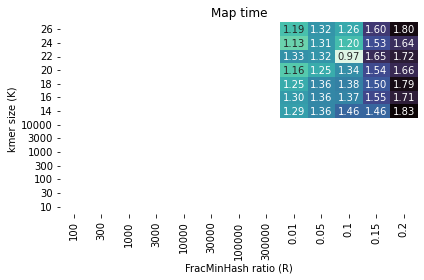

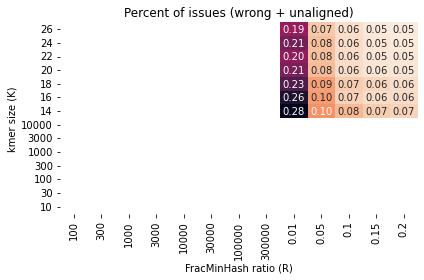

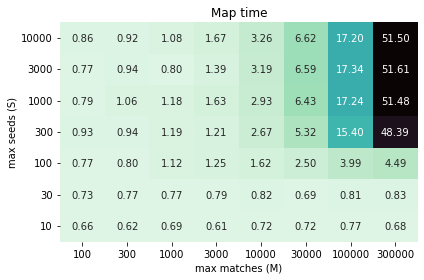

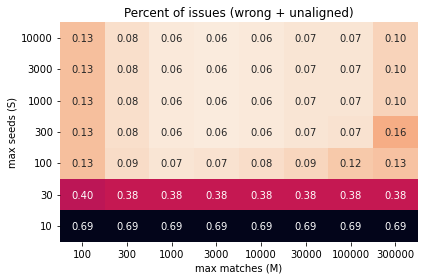

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

def read_matrix(Ys, Xs, ylabel, xlabel, experiment):
    TOOL = 'sweepmap'
    DATA = ('t2tChrY', 't2tChrY-a0.99-d1-l10000') # ('chm13', 'chm13-a0.99-d1-l10000')

    VARS = {'thinning': ('S', 'M'), 'sketching': ('K', 'R')}
    vary, varx = VARS[experiment]

    map_time_df = pd.DataFrame(index=Ys, columns=Xs)
    map_time_df.index.name = ylabel
    map_time_df.columns.name = xlabel
    issue_perc_df = map_time_df.copy() # pd.DataFrame(index=MAX_SEEDS, columns=MAX_MATCHES)

    for y in Ys:
        for x in Xs:
            refname, data = DATA
            reads = fasta2df(Path('reads') / Path('reads-'+data+'.fa'))
            pref = Path("out") / data / experiment / f'{TOOL}-{vary}{y}-{varx}{x}'
            eval_file = str(pref) + '.eval'
            unaligned,  aligned,  wrong,     issue_perc = get_eval(eval_file, len(reads))
            index_time, map_time, index_mem, total_mem  = get_times(pref)
            map_time_df.loc[y, x] = map_time
            issue_perc_df.loc[y, x] = issue_perc / 100.0

    return map_time_df, issue_perc_df

def plot_SM_heatmap(df, name, title, cm):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(df.astype(float), ax=ax, annot=True, fmt=".2f", cmap=cm, cbar=False)
    ax.set_title(title)
    ax.set_ylabel(df.index.name)
    ax.set_xlabel(df.columns.name)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    fig.savefig(f'imgs/{name}.png', dpi=300)
    plt.close(fig)

Ks = [14, 16, 18, 20, 22, 24, 26]
Rs = ['0.01', '0.05', '0.1', '0.15', '0.2']
KR_map_time_df, KR_issue_perc_df = read_matrix(Ks, Rs, 'kmer size (K)', 'FracMinHash ratio (R)', 'sketching')
plot_SM_heatmap(KR_map_time_df, name='heatmapKR_maptime', title='Map time', cm='mako_r')
plot_SM_heatmap(KR_issue_perc_df, name='heatmapKR_percissues', title='Percent of issues (wrong + unaligned)', cm='rocket_r')

MAX_SEEDS = [10, 30, 100, 300, 1000, 3000, 10000]
MAX_MATCHES = [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
SM_map_time_df, SM_issue_perc_df = read_matrix(MAX_SEEDS, MAX_MATCHES, 'max seeds (S)', 'max matches (M)', 'thinning')
plot_SM_heatmap(SM_map_time_df, name='heatmapSM_maptime', title='Map time', cm='mako_r')
plot_SM_heatmap(SM_issue_perc_df, name='heatmapSM_percissues', title='Percent of issues (wrong + unaligned)', cm='rocket_r')